<details>
   <summary>Metadata</summary>
    title: "E-TRAINEE Programming for point cloud analysis with Python"<br>
    description: "This is the second theme within the 3D/4D Geographic Point Cloud Time Series Analysis module."<br>
    dateCreated: 2022-03<br>
    authors: Katharina Anders, Bernhard Höfle<br>
    contributors: Sina Zumstein<br>
    estimatedTime: 1.5 hrs<br>
</details>

# Programming for point cloud analysis with Python

This theme provides an introduction how point cloud analyses can be performed using Python. Scripting in Python enables **to automate the processing and analysis** of 3D/4D point clouds. By this, workflows can be easily reproduced and transferred to other data or geographic regions. Python scripts can be easily shared with colleagues or the overall community (just like this Jupyter notebook), independent of the operating system. Parameters of the analysis can be adapted, and **analysis results can be directly output** in the form of new output layers (geodata files), statistics, or visualizations.

In this theme, you will learn about:
* <a href="#reading-handling-and-writing-point-cloud-data">Reading, handling, and writing point cloud data</a>
* <a href="#plotting-and-statistics">Plotting and statistics</a>
* <a href="#neighborhood-operations">Neighborhood operations</a>
* <a href="#rasterizing-point-clouds">Rasterizing point clouds</a>

After finishing this theme you will be able to:
* read and write point cloud data,
* rasterize point cloud information,
* perform simple comparisons of multitemporal point clouds,
* derive statistical information about point cloud properties and derived changes,
* create visualizations from the results, and
* ... and to include virtual laser scanning in the analysis (in the exercise)

## Requirements for this lesson

### Software and skills
To follow this theme hands-on and to perform the exercise, a Python installation and environment with specific packages is required. You can set up the Python environment for this course using the provided requirements file. Follow the [instructions in the software material](../../software/software_python.md).

### Data

The data used in this exercise are two point clouds of the *Hellstugubrean* glacier in the *Jotunheimen nasjonalpark*, Norway [61.5759° N, 8.4459° E](https://www.norgeskart.no/#!?project=norgeskart&layers=1002&zoom=11&lat=6844452.67&lon=152372.10&markerLat=6844452.666682822&markerLon=152372.10344584702&p=Koordinater&showSelection=false).
Data is provided by the *Norwegian Mapping Authority* under the [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/) License: © [Kartverket](https://www.kartverket.no/en/api-and-data/terms-of-use). The data was downloaded from [Høydedata](https://hoydedata.no/LaserInnsyn/) and cropped to an area of interest.

We use two acquisitions, an airborne laser scanning point cloud from 2009 with an average point density of 0.3 $pts/m^2$ and a dense image matching point cloud from 2017 with an average point density of 4 $pts/m^2$. Find the data in the directory `hellstugubrean` of the course data repository.

<center>
<img src="media/m3_theme2_hullstugubrean_pc_rgb.png" alt="Point cloud of Hullstugubrean colored by RGB" title="RGB-colored point cloud" width="600">

<i>Point cloud of Hullstugubrean glacier in Norway (epoch 2017) used for exercise throughout this theme. Figure by course authors. Data © [Kartverket](https://www.kartverket.no/en/api-and-data/terms-of-use) / [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/).</i></center>

<a id='reading-handling-and-writing-point-cloud-data'></a>
## Reading, handling, and writing point cloud data

In order to process point cloud data in Python, the data needs to be read from files into the working memory. Results of the processing should be written to point cloud files again. Point cloud data can be stored in [different file formats](../01_pointcloud_principles/01_pointcloud_principles.md). Throughout this theme, we will focus on the LAS format, as it is a binary format with low file sizes and the de-facto standard of point cloud data. For this, the [laspy](https://pypi.org/project/laspy/) package will be used (version >= 2.0).

#### Reading point cloud data
For the task of reading and writing point cloud data with Python, we will use the exercise point cloud `hellstugubrean_2009.las`. Specify the data locations in your local computer environment:

In [1]:
# define path to point cloud file
data_dir = 'path-to-data/hellstugubrean'

# check if the specified data path exists
import os
if not os.path.isdir(data_dir):
    print(f'ERROR: {data_dir} does not exist')
    print('Please specify the correct path to the data directory by replacing <path-to-data> above.')

pc_filename_in = 'hellstugubrean_2009.las'
pc_file_in = f'{data_dir}/{pc_filename_in}'


As reading of point cloud data is a repetitive task, we will create a function `read_las` for this. The function performs all general aspects required when reading point cloud data for analysis:
* Obtaining coordinate information (xyz) for each point
* Obtaining attribute information for each point, i.e. the name and value of each additional attribute

The main input parameter is the specification of the point cloud file to be read. The function returns a 2D array of the XYZ coordinates of all points. The array has the shape `(N,3)`, where `N` is the number of points in the point cloud. The function can additionally return the point attribute data. The attributes contained in point clouds can be very different, depending on the sensor, processing level, and application. Therefore, all available attributes will be read and returned in a dictionary, where the keys are the attribute names and the values are the attribute values as 1D array of shape `(N,1)`.

As many tasks need only the geometric information, i.e. coordinates, of the point cloud, we will add an optional parameter `get_attributes` (boolean, default: `False`). If we require the attribute information, the parameter must be set to `True`. Additionally, we add the parameter `use_every` to provide an easy way of subsampling the point cloud if required. Accordingly, the point cloud is subsampled by only returning every n-th point of the full dataset. The default value shall be `1`, i.e. returning the full point cloud data.

In [2]:
# import required modules
import laspy # import the laspy package for handling point cloud files
import numpy as np # import numpy for array handling

def read_las(infile,get_attributes=False,use_every=1):
    """
    Function to read coordinates and optionally attribute information of point cloud data from las/laz file.

    :param infile: specification of input file (format: las or laz)
    :param get_attributes: if True, will return all attributes in file, otherwise will only return coordinates (default is False)
    :param use_every: value specifies every n-th point to use from input, i.e. simple subsampling (default is 1, i.e. returning every point)
    :return: Array of point coordinates of shape (N,3) with N number of points in input file (or subsampled by 'use_every')
    """

    # read the file using the laspy read function
    indata = laspy.read(infile)

    # get the coordinates (XYZ) and stack them in a 3D array
    coords = np.vstack((indata.x, indata.y, indata.z)).transpose()

    # subsample the point cloud, if use_every = 1 will remain the full point cloud data
    coords = coords[::use_every, :]

    # read attributes if get_attributes is set to True
    if get_attributes == True:
        # get all attribute names in the las file as list
        las_fields= list(indata.points.point_format.dimension_names)

        # create a dictionary to store attributes
        attributes = {}

        # loop over all available fields in the las point cloud data
        for las_field in las_fields[3:]: # skip the first three fields, which contain coordinate information (X,Y,Z)
            attribute = np.array(indata.points[las_field]) # transpose shape to (N,1) to fit coordinates array
            if np.sum(attribute)==0: # if field contains only 0, it is empty
                continue
            # add the attribute to the dictionary with the name (las_field) as key
            attributes[las_field] = attribute[::use_every] # subsample by use_every, corresponding to point coordinates

        # return coordinates and attribute data
        return coords, attributes

    else: # get_attributes == False
        return coords  # return coordinates only

With this function, we can read the data from our point cloud file, including the point cloud attributes:

In [3]:
pc_coords, pc_attributes = read_las(pc_file_in, get_attributes=True)

We can check the properties of the point cloud by inspecting the returned coordinates `pc_coords` and attributes `pc_attributes`. For example, we can obtain the number of points and spatial extent from the coordinates array:

In [4]:
# get number of points from array shape
num_points = pc_coords.shape[0]
print(f'The point cloud consists of {num_points} points.')

# get spatial extent from minimum and maximum X,Y,Z coordinate values
min_coord_vals = np.min(pc_coords, axis=0)
max_coord_vals = np.max(pc_coords, axis=0)
print(f'The point cloud has a vertical extent of {max_coord_vals[2]-min_coord_vals[2]:.1f} m.')

The point cloud consists of 1694840 points.
The point cloud has a vertical extent of 583.3 m.


We can check the available attributes via the _keys_ of the dictionary `pc_attributes`:

In [5]:
pc_attributes.keys()

dict_keys(['intensity', 'return_number', 'number_of_returns', 'scan_direction_flag', 'classification', 'scan_angle_rank', 'user_data', 'gps_time'])

For a specific attribute, we may check which values occur in our dataset:

In [6]:
my_attr = 'number_of_returns'
print(f'The following values occur in the attribute {my_attr}: {np.unique(pc_attributes[my_attr])}')

The following values occur in the attribute number_of_returns: [1 2 3 4]


<a id='handling-point-cloud-data'></a>
### Handling point cloud data
In the following, we will use the attribute and coordinate information for filtering and spatial subsetting of the data, before writing the edited point cloud to a new output file.

#### Filtering by attribute

Editing of the point cloud data can be based on attribute information, for example using their value ranges or derived properties for filtering.

When performing analyses of the terrain, we may wish to remove points that do not represent solid object surfaces. In a simple approach, such points can be determined as measurements stemming from multiple returns wihin a single laser pulse. We therefore filter our point cloud data to contain only points which originate as single returns or last returns in case of multiple echos. This removes points which are first or intermediate echos of multiple returns and thereby represent penetrable objects, such as vegetation, or stem from edges which are hit by the beam while the pulse travels on until it hits the ultimate target surface.

As we know from the attribute dictionary, our point cloud contains information on each point's `return_number`and `number_of_returns`. From this, we can derive if a point is a single echo (`number_of_returns`=1) or one of multiple echos (`number_of_returns`>1). If a point originates from a beam with multiple echoes, we can derive if it is a first, intermediate or last echo by incorporating its `return_number`. To obtain this information for each point, we will create a new, additional attribute `echo_type` with values `{0:'single', 1:'first', 2:'intermediate', 3:'last'}`.

In [7]:
# dictionary of possible echo type values
echo_types_dict = {0:'single', 1:'first', 2:'intermediate', 3:'last'}

# derive per-point echo types using list comprehension based on attributes return_number and number_of_returns
echo_types = [0 if num_rets == 1 else 1 if ret_num == 1 else 3 if ret_num == num_rets else 2 for num_rets, ret_num in zip(pc_attributes['number_of_returns'],pc_attributes['return_number'])]

# add new list echo types to attributes as array to allow calculations
pc_attributes['echo_type'] = np.array(echo_types)

# check the occurrence and count of different echo types
echo_type_occ, echo_type_occ_count = np.unique(pc_attributes['echo_type'], return_counts = True)

print('The following echo types (count) occur in the attribute echo_type:')
for et, etc in zip(echo_type_occ, echo_type_occ_count):
    print(f'\t{echo_types_dict[et]} ({etc})')


The following echo types (count) occur in the attribute echo_type:
	single (1687948)
	first (3388)
	intermediate (94)
	last (3410)


We now remove all points with echo type first (`echo_type`=1) and intermediate (`echo_type`=2), i.e. maintaining only single and last echos.

In [8]:
# for every coordinate and attribute in point cloud, select only those where corresponding echo type is 0 or 3
pc_coords_filtered = pc_coords[(pc_attributes['echo_type']==0) | (pc_attributes['echo_type']==3)]
pc_attributes_filtered = {}
for k, v in pc_attributes.items():
    pc_attributes_filtered[k] = v[(pc_attributes['echo_type']==0) | (pc_attributes['echo_type']==3)]
    
# free working memory by setting original point cloud variables to None
pc_coords = None
pc_attributes = None

#### Spatial subsetting
We may further edit our point cloud data via spatial subsetting, i.e. maintaining only points whose coordinate are located in a certain area of interest. This area of interest can be defined via a simple 2D bounding box.

In [9]:
# 2D bounding box of area of interest (minimum X, minimum Y, maximum X, maximum Y)
aoi_bb = [470325.0, 6826505.0, 470815.0, 6827240.0]

# for every coordinate and attribute in point cloud select only those where corresponding XY coordinate is within minimum and maximum XY
sel_coords = (pc_coords_filtered[:,0]>=aoi_bb[0]) & (pc_coords_filtered[:,0]<=aoi_bb[2]) & (pc_coords_filtered[:,1]>=aoi_bb[1]) & (pc_coords_filtered[:,1]<=aoi_bb[3])
pc_coords_bb = pc_coords_filtered[sel_coords]
pc_attributes_bb = {}
for k, v in pc_attributes_filtered.items():
    pc_attributes_bb[k] = v[sel_coords]

In geographic analyses, spatial subsetting will often be based on polygon shapes. These can be defined, for example, in GIS as a shapefile. In the following, we will read a shapefile (`hellstugubrean.shp` provided with exercise data) that was created as area of interest and select only points located within the contained polygon.
First, we will read the polygon geometry from the shapefile:

In [10]:
# define path to shapefile
shp_filename_in = 'hellstugubrean_2009.shp'
shp_file_in = f'{data_dir}/{shp_filename_in}'

#read the file and check the contained Polygon
import geopandas as gpd

datasource = gpd.read_file(shp_file_in)

if datasource is None:
    print(f'Could not open shapefile {shp_file_in}, skipping cell content.')
else:
    polygons = gpd.GeoSeries(datasource['geometry'])
    print(polygons)

0    POLYGON ((470316.119 6826481.929, 470334.269 6...
Name: geometry, dtype: geometry


We will now loop over all coordinates in the point cloud and check if the respective point lies within the polygon. For this, we create an array which is used as boolean mask to subsequently select the inlier points from the full point cloud.

In [11]:
# create boolean array to mask points (initialize all entries as False)
pc_mask_polygon = np.full(len(pc_coords_filtered), fill_value=False, dtype=bool)

import shapely
from shapely.geometry import Point, Polygon

# loop over xy coordinates of all points
for pt_id, (x,y) in enumerate(pc_coords_filtered[:,:2]):
    point=Point([x,y])
    
    # check distance of this point to all polygons
    for poly in polygons:
        distance= poly.distance(point)
        # set mask to True, if point is within polygon
        if distance <= 0.0:
            pc_mask_polygon[pt_id] = True 
            
pc_coords_poly = pc_coords_filtered[pc_mask_polygon]
pc_attributes_poly = {}
for k, v in pc_attributes_filtered.items():
    pc_attributes_poly[k] = v[pc_mask_polygon]

We now obtained two different spatial point cloud subsets and can check, e.g., their point counts:

In [12]:
print(f'The attribute-filtered point cloud (single and last echos) contains {len(pc_coords_filtered)} points.')
print(f'The spatial subset using a 2D bounding box contains {len(pc_coords_bb)} points.')
print(f'The spatial subset using a polygon from a shapefile contains {len(pc_coords_poly)} points.')

The attribute-filtered point cloud (single and last echos) contains 1691358 points.
The spatial subset using a 2D bounding box contains 477524 points.
The spatial subset using a polygon from a shapefile contains 397098 points.


To visualize our results, we will subsequently go into plotting of point cloud data and derived information directly with Python. But first, the topic of point cloud handling will be concluded by writing out edited point cloud data to output files.

<a id='writing-point-cloud-data'></a>
### Writing point cloud data

Once editing of the point cloud is concluded, it can be stored to a new las file as final output. We write point clouds using a **function** which takes points and attributes as an input and writes them to a specified file path. Attributes to be written are optional, the default `attribute_dict` is empty.

In [13]:
def write_las(outpoints,outfilepath,attribute_dict={}):

    """
    :param outpoints: 3D array of points to be written to output file
    :param outfilepath: specification of output file (format: las or laz)
    :param attribute_dict: dictionary of attributes (key: name of attribute; value: 1D array of attribute values in order of points in 'outpoints'); if not specified, dictionary is empty and nothing is added
    :return: None
    """

    # create a header for new las file
    hdr = laspy.LasHeader(version="1.4", point_format=6)

    # create the las data
    las = laspy.LasData(hdr)

    # write coordinates into las data
    las.x = outpoints[:, 0]
    las.y = outpoints[:, 1]
    las.z = outpoints[:, 2]
    
    # add all dictionary entries to las data (if available)
    for key,vals in attribute_dict.items():
        try:
            las[key] = vals
        except:
            las.add_extra_dim(laspy.ExtraBytesParams(
                name=key,
                type=type(vals[0])
                ))
            las[key] = vals

    # write las file
    las.write(outfilepath)

    return


A point cloud, for example the filtered and spatial subset `pc_coords_poly` with attributed `pc_attributes_poly`, can now be saved to a new output file using the above function:

In [14]:
# define the output path
pc_subset_file = f'{data_dir}/hellstugubrean_2009_filtered_poly.las'

# write point cloud data to file with attributes
write_las(pc_coords_poly, pc_subset_file, attribute_dict=pc_attributes_poly)

You can now **check your written point cloud files in CloudCompare**. You will find that the newly created attribute `echo_type` is now available in the point cloud, which was contained in the attribute dictionary. The figure below shows the original point cloud `hellstugubrean_2009.las` (colored in blue) and the filtered and spatially subset point cloud `hellstugubrean_2009_filtered_poly.las` (colored by intensity in grayscale):

<center>

<img src="media/m3_theme2_pc_poly_visual.png" alt="Visualization of output point cloud in CloudCompare" title="Point clouds in CloudCompare" width="800">

<center><i>Visualization of output point cloud in CloudCompare (colored by intensity) compared to input point cloud with full spatial extent (colored in blue). The newly added echo type is available as attribute. Figure by course authors.</i></center>

Having finished this first part and written the output to file, we will release the point cloud data from memory. In the following part, we will use the full-size, filtered point cloud. Since we are going to include a second epoch (point cloud acquired in 2017) in the following, we will store this point cloud data in a new variable here, which explicitly contains the time information for easier processing.

In [15]:
# store point cloud data in new variables (make explicit copy and remove old ones from working memory)
pc_2009_coords = pc_coords_filtered.copy()
pc_2009_attributes = pc_attributes_filtered.copy()

# free working memory from all other point cloud objects
pc_coords_filtered = None
pc_attributes_filtered = None
pc_coords_bb = None
pc_attributes_bb = None
pc_coords_poly = None
pc_attributes_poly = None

<a id='plotting-and-statistics'></a>
## Plotting and statistics
In addition to writing outputs to point cloud files, the data can be visualized directly using Python functionality. Visualization can regard the point cloud data, i.e. the topography of the scene, but also information derived from the point cloud data, for example in the form of statistics. In the following, we use [matplotlib](https://matplotlib.org/) for plotting point cloud information.

In [16]:
# importing required modules
import matplotlib.pyplot as plt

Usually one of the first steps in data analysis is the exploration of (attribute) properties. The data may be easily checked via a **histogram**, which visualizes the frequency of occurrence of single values (in so-called bins). We will now create a histogram for the intensity attribute of our example point cloud (here using the spatial subset in the 2D bounding box).

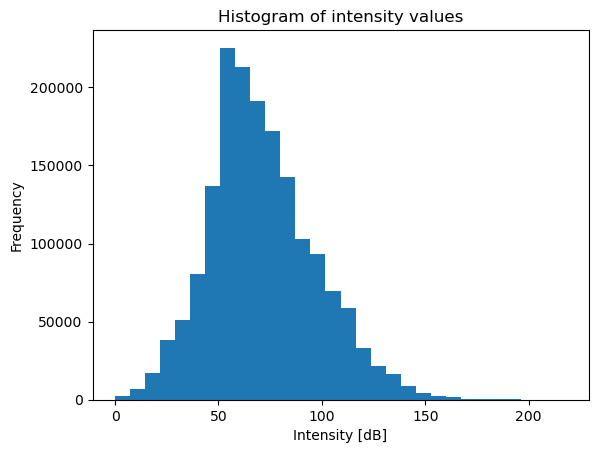

In [17]:
# define which point cloud data to use (already in memory from previous part)
my_attr = 'intensity'
data = pc_2009_attributes[my_attr]

# plot a simple histogram
plt.hist(data, bins=30)

# add axes labels
plt.xlabel('Intensity [dB]')
plt.ylabel('Frequency')

# add title
plt.title(f'Histogram of {my_attr} values')

# show the plot in interactive mode
plt.show() # or use this command to save the figure to file: plt.savefig('hist.png', dpi=300)

Any element of the matplotlib plot can be tweaked, such as the color, axis labels, tick format and labels, adding a legend, and many more. Check out the matplotlib gallery for many examples of how to adjust your plot layout: [https://matplotlib.org/stable/gallery/index](https://matplotlib.org/stable/gallery/index)

We may further explore the data via **descriptive statistics**. Properties such as the mean and standard deviation, or percentiles of attribute values provide us insight into the distribution of attribute values. Here, we can directly make use of the powerful `numpy` array operations and functions.

In [18]:
data_mean = np.mean(data)
data_stdev = np.std(data)
print(f'The data ({my_attr}) has a mean of {data_mean:.1f} and standard deviation of {data_stdev:.1f}.')

The data (intensity) has a mean of 71.3 and standard deviation of 25.6.


We may add this information directly into our plots, visually or as text. This time, we will further adjust the layout of the figure:

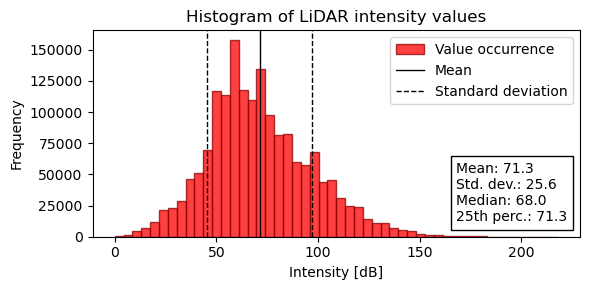

In [19]:
# create the figure object
fig, ax = plt.subplots(figsize=(6,3))

# plot the histogram of data with keyword arguments to add a label (legend) and adapt the layout
ax.hist(data, bins=50, label='Value occurrence', facecolor='red', alpha=.75, edgecolor='darkred')

# add title and axis labels
ax.set_title(f'Histogram of LiDAR intensity values')
ax.set_xlabel('Intensity [dB]')
ax.set_ylabel('Frequency')

# add vertical lines of mean and standard deviation
ax.axvline(data_mean, color='black', linewidth=1.0, label='Mean')
ax.axvline(data_mean-data_stdev, color='black', linewidth=1.0, linestyle='--', label='Standard deviation')
ax.axvline(data_mean+data_stdev, color='black', linewidth=1.0, linestyle='--')

# add statistical values as text 
from matplotlib.offsetbox import AnchoredText # use anchored text for automatic positioning in the figure
anchored_text = AnchoredText(f'Mean: {data_mean:.1f}\nStd. dev.: {data_stdev:.1f}\nMedian: {np.median(data):.1f}\n25th perc.: {np.percentile(data_mean,25):.1f}', loc='lower right')
ax.add_artist(anchored_text)

# add legend
plt.legend()

# cleanly fit plots within figure
plt.tight_layout()

# show plot in interactive mode
plt.show()

We can further explore our topographic laser scanning point cloud by checking the spatial distribution of an attribute. In 2D, points can be plotted in a **scatter plot**. To not introduce distortion between the x- and y-axis, we need to set the aspect ratio to `equal`. We then use the intensity attribute as color, which is set via the argument `c` of the `scatter()` function. We select a colormap (here: `cmap='copper'`) and decrease the size of the markers to render the points better visible (`s=1`).

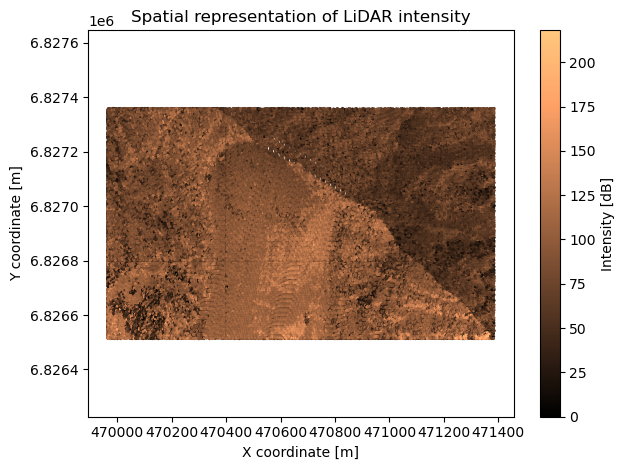

In [20]:
# create the figure object
fig, ax = plt.subplots()
ax.axis('equal') # make axis ratio equal to avoid distortion between x and y

# scatter the x and y coordinates and color by intensity
nth = 10 # use only every n-th point to improve visibility
sp = ax.scatter(pc_2009_coords[:,0][::nth], pc_2009_coords[:,1][::nth], c=pc_2009_attributes['intensity'][::nth], cmap='copper', s=1)

# add title and axis labels
ax.set_title(f'Spatial representation of LiDAR intensity')
ax.set_xlabel('X coordinate [m]')
ax.set_ylabel('Y coordinate [m]')

# add a colorbar legend
cb = plt.colorbar(sp)
cb.set_label('Intensity [dB]')

# cleanly fit plots within figure
plt.tight_layout()

# show the plot in interactive mode
plt.show()


Since we are interested in observing changes through multitemporal or time series of 3D geodata, at this point we will load a second point cloud of the same area, which was acquired in 2017, and visually compare it to the 2009 dataset. Methods of change detection and quantification in the topography, are part of the subsequent theme on [Principles and basic algorithms of 3D change detection and analysis](../03_3d_change_analysis/03_3d_change_analysis.ipynb).

In [21]:
# read point cloud data of 2017 epoch using the function defined above
pc_filename_in = 'hellstugubrean_2017.las'
pc_file_in = f'{data_dir}/{pc_filename_in}'
pc_2017_coords, pc_2017_attributes = read_las(pc_file_in, get_attributes=True)

# note: we are not applying the same echo type filtering here
# in real analysis, you might make this filtering step a function and apply it to each of your epochs

Having read both epochs of point clouds, we will now create a plot with two columns, where one epoch will be displayed on each side with same formatting and layout for visual comparison.

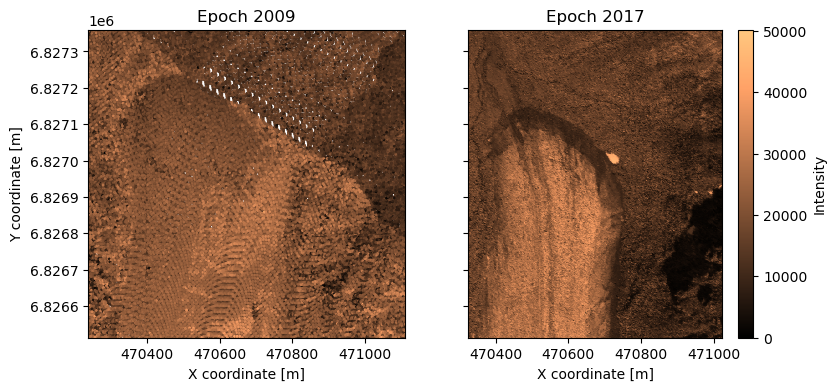

In [22]:
# create the figure object with one row, two columns
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(9,4)) # the x and y axis extent should be exactly the same
for ax in axs:
    ax.axis('equal') # make axis ratio equal to avoid distortion between x and y

ax1, ax2 = axs # one axis to plot each epoch
    
# scatter the x and y coordinates and color by intensity
nth = 10 # use only every n-th point to improve visibility
sp1 = ax1.scatter(pc_2009_coords[:,0][::nth], pc_2009_coords[:,1][::nth], c=pc_2009_attributes['intensity'][::nth], cmap='copper', s=1)
sp2 = ax2.scatter(pc_2017_coords[:,0][::nth], pc_2017_coords[:,1][::nth], c=pc_2017_attributes['intensity'][::nth], cmap='copper', s=1)

# add title and axis labels
ax1.set_title(f'Epoch 2009')
ax1.set_xlabel('X coordinate [m]')
ax1.set_ylabel('Y coordinate [m]')
ax2.set_title(f'Epoch 2017')
ax2.set_xlabel('X coordinate [m]')

# make sure both plots have the same x extent
ax1.set_xlim(min(pc_2009_coords[:,0]), max(pc_2009_coords[:,0]))
ax2.set_xlim(min(pc_2009_coords[:,0]), max(pc_2009_coords[:,0]))
ax1.set_ylim(min(pc_2009_coords[:,1]), max(pc_2009_coords[:,1]))
ax2.set_ylim(min(pc_2009_coords[:,1]), max(pc_2009_coords[:,1]))


# add a colorbar legend (to the second axis to be right of the figure)
cb = plt.colorbar(sp2)
cb.set_label('Intensity')

plt.show()

We can now **visually identify differences in the data properties as well as changes in the scene**. The glacier outline becomes much better visible in the 2017 data, likely because the data quality improved regarding the processing and range-dependent correction of intensity data from the different airborne laser scanning strips. Making out the glacier outline in 2009, we can also determine that the glacier retreated between these two epochs. To better visualize this retreat, we will add the glacier outline of 2009 to the plots. The outline is contained as polygon in the shapefile `hellstugubrean.shp`. The polygon geometry is still contained in our `all_geoms` object created in the first part of this theme.

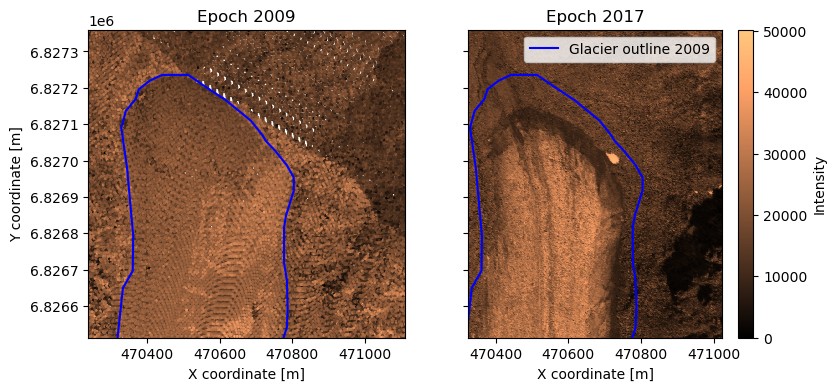

In [23]:
%matplotlib inline
# get the outline of the polygon
glacier_poly= polygons[0]
glacier_poly_outring = glacier_poly.boundary

x,y = glacier_poly.exterior.xy

# create the figure object with one row, two columns
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(9,4)) # the x and y axis extent should be exactly the same
for ax in axs:
    ax.axis('equal') # make axis ratio equal to avoid distortion between x and y

ax1, ax2 = axs # one axis to plot each epoch
    
# scatter the x and y coordinates and color by intensity
nth = 10 # use only every n-th point to improve visibility
sp1 = ax1.scatter(pc_2009_coords[:,0][::nth], pc_2009_coords[:,1][::nth], c=pc_2009_attributes['intensity'][::nth], cmap='copper', s=1)
sp2 = ax2.scatter(pc_2017_coords[:,0][::nth], pc_2017_coords[:,1][::nth], c=pc_2017_attributes['intensity'][::nth], cmap='copper', s=1)


# add title and axis labels
ax1.set_title(f'Epoch 2009')
ax1.set_xlabel('X coordinate [m]')
ax1.set_ylabel('Y coordinate [m]')
ax2.set_title(f'Epoch 2017')
ax2.set_xlabel('X coordinate [m]')

# make sure both plots have the same x extent
ax1.set_xlim(min(pc_2009_coords[:,0]), max(pc_2009_coords[:,0]))
ax2.set_xlim(min(pc_2009_coords[:,0]), max(pc_2009_coords[:,0]))
ax1.set_ylim(min(pc_2009_coords[:,1]), max(pc_2009_coords[:,1]))
ax2.set_ylim(min(pc_2009_coords[:,1]), max(pc_2009_coords[:,1]))

# add a colorbar legend (to the second axis to be right of the figure)
cb = plt.colorbar(sp2)
cb.set_label('Intensity')

# add the glacier outline to the plot
ax1.plot(x,y, color='blue', lw=1.5, label = 'Glacier outline 2009')
ax2.plot(x,y, color='blue', lw=1.5, label = 'Glacier outline 2009')

# add a legend
ax2.legend(loc='upper right')

plt.show()

In the final plot above, it becomes clearly visible how much the glacier retreated.

To include information on the elevation in our visualization, we may advance our figure to a 3D plot. In the following, we will plot the point cloud data of the 2017 epoch in a 3D scatter plot.

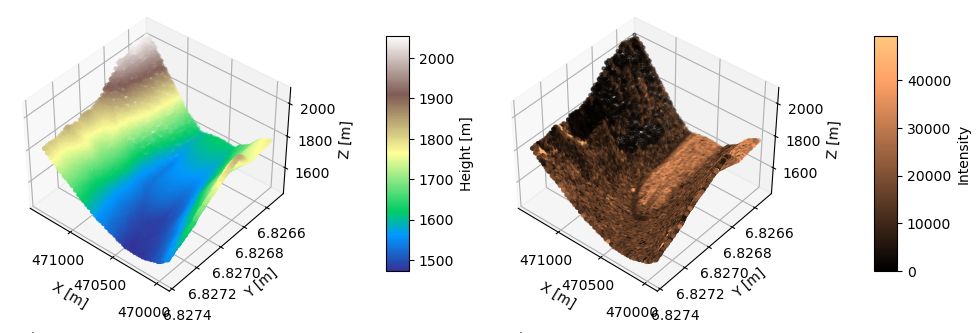

In [24]:
# create a figure with 3D axis (two columns for different coloring)
fig, axs = plt.subplots(1,2,subplot_kw={"projection": "3d"},figsize=(10,5))
ax1, ax2 = axs

nth=500

# plot the point cloud colored by height (z values)
surf = ax1.scatter(pc_2017_coords[::nth,0], pc_2017_coords[::nth,1], pc_2017_coords[::nth,2], s=5,
                   c=pc_2017_coords[::nth,2],cmap=plt.cm.terrain)

# plot the point cloud colored by intensity
intens = ax2.scatter(pc_2017_coords[::nth,0], pc_2017_coords[::nth,1], pc_2017_coords[::nth,2], s=5,
                   c=pc_2017_attributes['intensity'][::nth],cmap='copper')


# label axes and add title
for ax in axs:
    ax.set_xlabel('X [m]')
    ax.set_ylabel('Y [m]')
    ax.set_zlabel('Z [m]')
    
    # set initial view of 3D plot
    ax.view_init(elev=40., azim=130.)

# add colorbars
fig.colorbar(surf, shrink=.5, aspect=10, label='Height [m]', ax=ax1, pad=0.2)
fig.colorbar(intens, shrink=.5, aspect=10, label='Intensity', ax=ax2, pad=0.2)

# show the plot
plt.tight_layout()
plt.show()

We may additionally plot the glacier outline as polygon here. To make it visible on the 3D surface, we need to add elevation (Z) values to the XY coordinates. We may grab these values from the point cloud data. This is a neighborhood operation, which can be efficiently done using suitable data structures (e.g., a kd-tree) and corresponding search functions. This will be introduced in the [next section](#neighbourhood-operations) of this theme.

As a last part of visualization, we would like to hint to the [Python package](https://polyscope.run/py/) `polyscope`, a viewer and user interface for 3D data (such as meshes and point clouds). Interactive 3D visualizations in a user interface (UI) can be created and customized with few lines of code:

In [25]:
import polyscope as ps

ps.init() # initialize polyscope

ps_cloud = ps.register_point_cloud("Glacier 2017", pc_2017_coords) # register a point cloud

ps.set_up_dir("z_up") # orient the point cloud correctly

ps.show() # view the point cloud and mesh we just registered in the 3D UI

If you'd like to use polyscope, find further examples and usage guidelines in the [polyscope documentation](https://polyscope.run/py/).

<a id='neighborhood-operations'></a>
## Neighborhood operations
	
Neighborhood operations are key to many processing steps of 3D geodata analysis. The concepts of neighborhood operations are part of [Theme 1](../01_pointcloud_principles/01_pointcloud_principles.md). Now we will consider them in practice.

<a id='spatial-data-structure'></a>
### Spatial data structure for neighborhood operations: kd-tree

How would you find the nearest neighbor of a point in a point cloud? By checking the distance of each point and selecting the one with the shortest distance. Checking each point for every neighborhood search takes a lot of time. But we can make use of spatial indexing to speed up the process. This means, we can immediately exclude a large portion of points, which are not in the same spatial area as our search point. We will use a kd-tree as data structure for efficient neighborhood searches. 

A kd-tree is a **binary tree** that splits a dataset by using nodes. When no more splitting is possible the created splitted datasets are called leaf cells. The dataset is divided at any non-leaf node into two equally sized subsets of the data. If you want to learn more about kd-trees, you  may have a look at [this video](https://youtu.be/Glp7THUpGow).
In this course, we will use the kd-tree in in the [Python package](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.KDTree.html) `scipy.spatial`. 

We start by building a kd-tree for the point cloud epoch of 2017:

In [26]:
# import required module
from scipy.spatial import KDTree

# build kd-tree from 3D coordinates
tree2017 = KDTree(pc_2017_coords)

The kd-tree can be used to search the neighborhood of 3D points efficiently. The k nearest neighbors of a set of search points (same number of dimensions as the kd-tree) can be queried using the [scipy function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.KDTree.query.html) `query`. The neighbors in the spatial neighborhood can be queried using the function `query_ball_point` for a specified radius.

#### Estimating point density

A commonly provided metric to describe point cloud data is the 2D point density, i.e. information about the average number of points per square meter. We can derive these, by searching all points in the 2D neighborhood of XY coordinates. To obtain a meaningful estimate, we need to compute the point density using a regular grid of 2D locations (XY coordinates) as search points.

In [27]:
# create a 2D kd-tree from the point cloud
tree2017_2d = KDTree(pc_2017_coords[:,:2])

# create a grid of XY coordinates with 1.0 m resolution and spatial extent of the point cloud
X = np.arange(int(np.min(pc_2017_coords[:,0])), int(np.max(pc_2017_coords[:,0]) + 0.5), 1.0)
Y = np.arange(int(np.min(pc_2017_coords[:,1])), int(np.max(pc_2017_coords[:,1]) + 0.5), 1.0)
X, Y = np.meshgrid(X, Y)
search_locs = np.vstack((X.flatten(),Y.flatten())).transpose()

# determine the neighboring points within radius r of each point using a 2D kd-tree
# use return_length to return the number of points, instead of their indices
num_neighs = tree2017_2d.query_ball_point(search_locs, r=0.5, return_length=True)

The 1D array `num_neighs`contains the number of neighboring points per input search location. From this we can derive the average as point density per square meter (appr. due to search radius of 0.5 m):

In [28]:
pdens_2d = np.mean(num_neighs)
print(f'The mean point density in the point cloud is {pdens_2d:.1f} pts/m².')

The mean point density in the point cloud is 3.9 pts/m².


#### Nearest neighbor search in multitemporal point clouds

The neighborhood search allows us to perform a first simple change analysis in multitemporal point clouds. Using the two epochs of 2009 and 2017, for each point in one epoch we can determine the closest point in the other epoch and derive their Euclidian distance.
We will use the 3D kdtree `tree2017` created above and search the nearest neighbor (`k=1`) for each point in the 2009 point cloud epoch.

In [29]:
# query indices of nearest neighbors of 2009 coordinates in 2017 kd-tree
nn_dists = tree2017.query(pc_2009_coords, k=1)

The `query()`function returns both the distances to the nearest neighbors and their index in the search point cloud. Therefore, the distances are directly available and can be plotted for visual inspection:

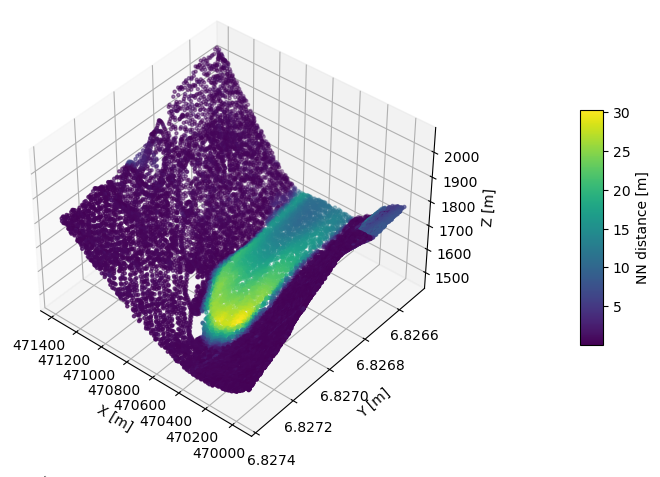

In [30]:
# obtain distances as first element in tuple returned by query above
distances = nn_dists[0]

# create a figure with 3D axis (two columns for different coloring)
fig, ax = plt.subplots(1,1,subplot_kw={"projection": "3d"},figsize=(7,5))

nth=100

# plot the point cloud colored by height (z values)
s = ax.scatter(pc_2009_coords[::nth,0], pc_2009_coords[::nth,1], pc_2009_coords[::nth,2], s=5,
                   c=distances[::nth])

# label axes and add title
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_zlabel('Z [m]')

# set initial view of 3D plot
ax.view_init(elev=40., azim=130.)

# add a colorbar
fig.colorbar(s, shrink=.5, aspect=10, label='NN distance [m]', ax = ax, pad=0.2)

# show the plot
plt.tight_layout()
plt.show()

We now obtained our **first 3D change information**: The distances between points from one epoch to the nearest points in the other epoch show us large distances (up to 30 m) on the glacier. This indicates that there were strong changes of glacier retreat and/or volume loss. In contrast, distance values are small to zero on the surrounding rock slopes, which are hence mostly stable or unchanged.

To further assess and interpret changes in such a 3D scene, concepts of 3D change analysis including types and directions of changes, and associated uncertainties are introduced in detail in the next theme on [Principles and basic algorithms of 3D change detection and analysis](../03_3d_change_analysis/03_3d_change_analysis.ipynb).

The following section regards the derivation of rasters from 3D point cloud data.

<a id='rasterizing-point-clouds'></a>
## Rasterizing point cloud data

Many workflows of point cloud analysis yield a GIS layer in the form of rasters as result. Rasterizing 3D point clouds means to assign one value to each raster pixel. For example, creating a raster of Z values representing the terrain surface yields a Digital Terrain Model (DTM), or Digital Elevation Model (DEM) in more general terms (cf. previous theme on [Principles of 3D/4D geographic point clouds](../01_pointcloud_principles/01_pointcloud_principles.md)).

To further process point clouds and deriving rasters, we are going to include [PDAL](https://pdal.io/en/latest/about.html), the open source "Point Data Abstraction Library" which offers functionality for processing point cloud data. It offers many common and special methods and algorithms to process point clouds. In this course, we are going to make use of [PDAL's Python support](https://pdal.io/en/latest/python.html).

In [31]:
import pdal

Our aim is to rasterize the terrain of our glacier point clouds to obtain a DTM. A simple approach is to assign each raster pixel the minimum Z value that occurs in the area of the pixel (of defined spatial resolution).

In [32]:
# define the point cloud paths for both epochs
pc_2009 = f'{data_dir}/hellstugubrean_2009.las'
pc_2017 = f'{data_dir}/hellstugubrean_2017.las'

# replacing backslashes by forward slashes is required for some Windows paths
pc_2009 = pc_2009.replace("\\", "/")
pc_2017 = pc_2017.replace("\\", "/")

# define the DTM raster file name based on the input file name
dtm_2009 = pc_2009.replace(".las", "_dtm.tif")
dtm_2017 = pc_2017.replace(".las", "_dtm.tif")

PDAL works in so-called [stages](https://pdal.io/en/latest/stages/stages.html), divided into readers, filters and writers. The processing of data in PDAL is defined in a [pipeline](https://pdal.io/en/latest/pipeline.html), which may consist of different stages. In our case, we will perform two steps: (1) reading the point cloud from las, and (2) writing the elevation to a raster. The pipeline is formatted in json:

In [33]:
json_dtm = """[
    "%s",
    {
        "type":"writers.gdal",
        "filename": "%s",
        "output_type":"min",
        "gdaldriver":"GTiff",
        "resolution":5.0,
        "window_size":8
    }
]"""  

In the above definition of the pipeline as json, we did not yet define the variable of the input point cloud file and the output raster file. They are represented by `%s` and can be used for string formatting. By this, we can use the same pipeline template for different inputs and outputs.

In [34]:
json_dtm_2009 = json_dtm % (pc_2009, dtm_2009)
json_dtm_2017 = json_dtm % (pc_2017, dtm_2017)

Using the json format, we can construct a PDAL pipeline and execute it:

In [35]:
pipeline = pdal.Pipeline(json_dtm_2009)
exe = pipeline.execute()

We create the same DTM for the 2017 epoch:

In [36]:
pipeline = pdal.Pipeline(json_dtm_2017)
exe = pipeline.execute()

In your data directory, you will now find the generated raster files in GeoTiff format. Check it out in QGIS:

<center>
<img src="media/m3_theme2_glacier_dtms.gif" alt="DTM hillshade of both epochs in QGIS" title="Hillshades in QGIS" width="600">

<center><i>Digital terrain models (DTMs) in QGIS with render type 'Hillshade', which visualizes the terrain and especially glacier surface changes between the two epochs. Figure by course authors.</i></center>

To assess raster-based changes in the terrain, we can simply subtract the two DTMs. This will provide the difference in local elevation (Z values) for each pixel (more on that in the next theme). 
We will read the raster data into a numpy array using [rasterio](https://rasterio.readthedocs.io/en/latest/).

In [37]:
import rasterio as rio

with rio.open(dtm_2009) as src:
    dtm_2009_data = src.read(1, masked=True)

with rio.open(dtm_2017) as src:
    dtm_2017_data = src.read(1, masked=True)

The difference between the two is obtained by simply subtracting one epoch from the other:

In [38]:
dtm_diff = dtm_2017_data - dtm_2009_data

We use Python plots to visualize the result:

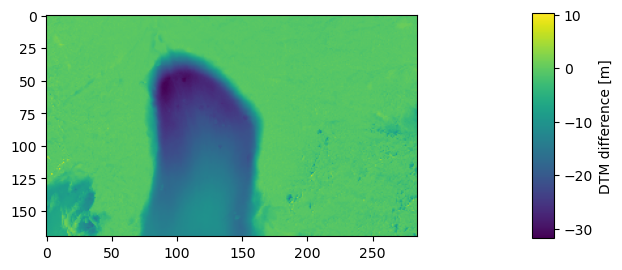

In [39]:
# create a figure 
fig, ax = plt.subplots(1,1)

# plot the difference values in the 2D array
m = ax.imshow(dtm_diff, aspect='equal')

# add a colorbar
fig.colorbar(m, shrink=.5, aspect=10, label='DTM difference [m]', ax = ax, pad=0.2)

# show the plot
plt.tight_layout()
plt.show()

We see a similar result as for the temporal neighbor search in the point cloud above. By subtracting the DTMs (later minus earlier epochs), we already obtained a correct sign of distances. Where the surface decreased - on the glacier - the values are negative. However, there are important advantages of conducting the change analysis in 3D on the point cloud. You will learn about them in the next theme, including approaches which account for the direction of changes. But first, finish this theme by proceeding with the exercise!

<a id='exercise'></a>
## Exercise 

Since this theme is highly practical, there is no self-evaluation quiz. You will assess your achieved skills in practice, by performing the exercise. In the exercise, you will use virtual laser scanning with HELIOS++ in Python to assess how the acquisition strategy - airborne instead of UAV laser scanning - influences the changes derived for rock glacier monitoring.

Proceed with the exercise by going to the next page below or directly [download the Jupyter Notebook](./exercise/m3_theme2_exercise1.ipynb).